# SETUP

In [40]:
num_gaussians = 7

In [1]:
import time
beginning_time = time.time()

import sys
sys.path.append("../Code/")
from utils import performance

import os
DATA_DIR = os.path.join('..', 'Data')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
def timtime(t):
    print(">",int(time.time()- t), "seconds elapsed")

# LOAD DATA

In [3]:
# sparse might be important?

develop = False
        
train_X = pd.concat([pd.read_pickle(os.path.join(DATA_DIR, 'train_X_1')), 
                     pd.read_pickle(os.path.join(DATA_DIR, 'train_X_2'))])
train_y = pd.read_pickle(os.path.join(DATA_DIR, 'train_y'))
valid_X = pd.read_pickle(os.path.join(DATA_DIR, 'valid_X'))
valid_y = pd.read_pickle(os.path.join(DATA_DIR, 'valid_y'))

if develop:
    train_X = train_X[0:10000]
    train_y = train_y[0:10000]
    valid_X = valid_X[0:1000]
    valid_y = valid_y[0:1000]

In [4]:
test_X = pd.read_pickle(os.path.join(DATA_DIR, 'test_X'))

# Build GMM

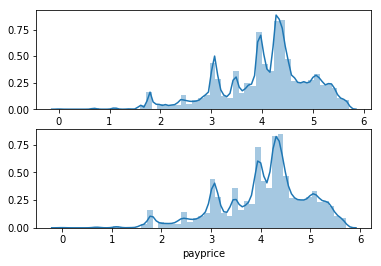

In [5]:
# first visualise data
f, (ax1, ax2) = plt.subplots(2)

sns.distplot(np.log1p(train_y.payprice), ax=ax1)
ax1.set_xlabel('Train log normal pay price')

sns.distplot(np.log1p(valid_y.payprice), ax=ax2)
ax1.set_xlabel('Valid log normal pay price')

plt.show()

In [6]:
from sklearn.mixture import GaussianMixture
GMM = GaussianMixture(n_components=num_gaussians, max_iter=100, random_state=1)

train_payprice = np.array(np.log1p(train_y.payprice))
# need two dimensions
a = np.shape(train_payprice)[0]
tpp2d = np.reshape(train_payprice, (a,1))

In [7]:
GMM.fit(tpp2d)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=7, n_init=1, precisions_init=None,
        random_state=1, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [8]:
# now sample from the GMM to check visually that it has fit the data
N = len(train_y)

sample_x, sample_y = GMM.sample(n_samples=N)

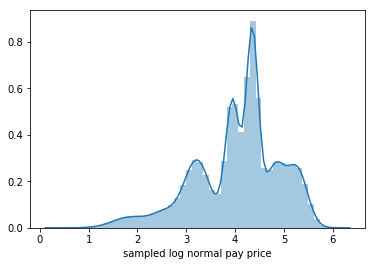

In [9]:
sns.distplot(sample_x)
plt.xlabel('sampled log normal pay price')
plt.show()

# Price category classifier

In [10]:
from scipy.sparse import csr_matrix
train_X = csr_matrix(train_X) 
valid_X = csr_matrix(valid_X)

In [11]:
from sklearn.metrics import log_loss #<--- think this should be the loss funciton

In [12]:
train_true_classes = GMM.predict(tpp2d)

In [13]:
#make a validation set
valid_payprice = np.array(np.log1p(valid_y.payprice))
a = np.shape(valid_payprice)[0]
vpp2d = np.reshape(valid_payprice, (a,1))

valid_true_classes = GMM.predict(vpp2d)

In [14]:
from xgboost import XGBClassifier

In [41]:
# check if classes are inbalanced
for c in range(num_gaussians):
    print("class:",c,"-- members:", np.sum(train_true_classes==c), 
         "-- percent", 100*(np.sum(train_true_classes==c))//len(train_true_classes))

class: 0 -- members: 664545 -- percent 27
class: 1 -- members: 99184 -- percent 4
class: 2 -- members: 500311 -- percent 20
class: 3 -- members: 315991 -- percent 12
class: 4 -- members: 474914 -- percent 19
class: 5 -- members: 301072 -- percent 12
class: 6 -- members: 74964 -- percent 3


In [16]:
2+2

4

In [17]:
model = XGBClassifier(max_depth=6, learning_rate=0.1, n_estimators=75, 
                      random_state=0, objective="multi:softmax")

In [18]:
model.fit(train_X, train_true_classes, eval_set=[(valid_X, valid_true_classes)], 
                   verbose=True, early_stopping_rounds=7)

[0]	validation_0-merror:0.45756
Will train until validation_0-merror hasn't improved in 7 rounds.
[1]	validation_0-merror:0.448999
[2]	validation_0-merror:0.448387
[3]	validation_0-merror:0.443481
[4]	validation_0-merror:0.444682
[5]	validation_0-merror:0.44532
[6]	validation_0-merror:0.44406
[7]	validation_0-merror:0.444064
[8]	validation_0-merror:0.444764
[9]	validation_0-merror:0.441517
[10]	validation_0-merror:0.44204
[11]	validation_0-merror:0.441346
[12]	validation_0-merror:0.440319
[13]	validation_0-merror:0.440418
[14]	validation_0-merror:0.43999
[15]	validation_0-merror:0.439737
[16]	validation_0-merror:0.43973
[17]	validation_0-merror:0.438763
[18]	validation_0-merror:0.437963
[19]	validation_0-merror:0.438447
[20]	validation_0-merror:0.438562
[21]	validation_0-merror:0.436894
[22]	validation_0-merror:0.434986
[23]	validation_0-merror:0.434094
[24]	validation_0-merror:0.433255
[25]	validation_0-merror:0.432956
[26]	validation_0-merror:0.432988
[27]	validation_0-merror:0.43278

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=75,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

model = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

In [ ]:
## could check the MSE to see if it is close to 8000

In [21]:
train_pred_class = model.predict(train_X)

In [22]:
# check if classes are inbalanced
for c in range(num_gaussians):
    print("class:",c,"-- members:", np.sum(train_true_classes==c), 
         "-- percent", 100*(np.sum(train_true_classes==c))//len(train_true_classes))

class: 0 -- members: 664545 -- percent 27
class: 1 -- members: 99184 -- percent 4
class: 2 -- members: 500311 -- percent 20
class: 3 -- members: 315991 -- percent 12
class: 4 -- members: 474914 -- percent 19
class: 5 -- members: 301072 -- percent 12
class: 6 -- members: 74964 -- percent 3


In [25]:
# check if classes are inbalanced
for c in range(num_gaussians):
    print("class:",c,"-- members:", np.sum(train_pred_class==c), 
         "-- percent", 100*(np.sum(train_pred_class==c))//len(train_true_classes))

class: 0 -- members: 590741 -- percent 24
class: 1 -- members: 76053 -- percent 3
class: 2 -- members: 763642 -- percent 31
class: 3 -- members: 187597 -- percent 7
class: 4 -- members: 564515 -- percent 23
class: 5 -- members: 226016 -- percent 9
class: 6 -- members: 22417 -- percent 0


In [30]:
L = len(train_y)

train_gauss_price = np.zeros(L)
train_predict_price = np.zeros(L)

for x in range(L):
    c1 = train_true_classes[x]
    p1 = GMM.means_[c1,0]
    train_gauss_price[x] = p1
    
    c2 = train_pred_class[x]
    p2 = GMM.means_[c2,0]
    train_predict_price[x] = p2

train_gauss_price = np.expm1(train_gauss_price)    
train_predict_price = np.expm1(train_predict_price)

In [38]:
np.expm1(GMM.means_)

array([[  76.60928052],
       [   5.6142484 ],
       [  23.9647042 ],
       [ 193.88739247],
       [  50.8579809 ],
       [ 121.66458847],
       [  11.71334609]])

In [35]:
from sklearn.metrics import mean_squared_error as mse

In [39]:
mse(np.log1p(train_gauss_price), np.log1p(train_predict_price))

0.60384236392201274

In [36]:
mse(train_gauss_price, train_predict_price)

2782.6772577283768

In [37]:
np.sqrt(2782)

52.744667976962376

In [42]:
import pickle
pkl_filename = "../Models/GMM7_GBDT.pkl"  

with open(pkl_filename, 'wb') as file:  
    pickle.dump(model, file)

### IS MEAN + 1 + K*standard deviation greater than the actual market price?

In [44]:
np.sum(train_predict_price+1>train_y.payprice)/L

0.49553739827666282

In [45]:
for K in [0,0.5,1,1.5,2,2.5,3]:
    print("++++ k={} ++++".format(K))
    
    train_bid = np.zeros(L)
    
    for x in range(L):
        c = train_pred_class[x]
        mu = GMM.means_[c,0]
        sig = np.sqrt(GMM.covariances_[c, 0, 0])
        
        p = mu + K*sig
        train_bid[x] = p
    
    train_bid = np.expm1(train_bid)
    print(np.sum(train_bid>train_y.payprice)/L)
    print(np.sum(train_bid+1>train_y.payprice)/L)   
    print()

++++ k=0 ++++
0.456057451704
0.495537398277

++++ k=0.5 ++++
0.56410354503
0.59125061035

++++ k=1 ++++
0.653737729748
0.664363481245

++++ k=1.5 ++++
0.713875180431
0.718656377816

++++ k=2 ++++
0.744302814378
0.749363322873

++++ k=2.5 ++++
0.770835724343
0.774711114567

++++ k=3 ++++
0.796364512927
0.799570214658

